In [16]:
import numpy as np
import sklearn.datasets
import pickle as pkl

import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()

In [17]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        p = X.shape[0]
        n = Y.shape[0]
        dim = X.shape[1:]
        X = np.reshape(X, (p,1) + dim)
        Y = np.reshape(Y, (1,n) + dim)
        D = np.sum((X - Y)**2, axis = -1)
        return  np.exp(-D/(self.sigma**2)) ## Matrix of shape NxM

In [18]:
class Linear:
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return np.dot(X,Y.T)## Matrix of shape NxM

### Weighted Kernel Ridge Regression

In [19]:
class WKernelRR:

    def __init__(self, kernel: [RBF| Linear| list[list[float]] | np.ndarray], lmbda: float, weight: list[float] = None):
        self.lmbda = lmbda
        self.kernel = kernel
        self.alpha = None 
        self.b = None
        self.support = None
        self.type='ridge'
        self.weight = weight

    def fit(self, X, y):

        N = X.shape[0] #Number of samples
        X = X.reshape(N,-1)
        
        if isinstance(self.weight, type(None)):
            self.weight = np.ones(N)
        elif isinstance(self.weight, list) or isinstance(self.weight, np.ndarray):
            assert all(self.weight > 0), "The weights of the matrix should all be positive."
            self.weight = np.sqrt(self.weight)

        self.support = X

        if isinstance(self.kernel, RBF) or isinstance(self.kernel, Linear):
            K = self.kernel(X,X)
        elif isinstance(self.kernel, list) or isinstance(self.kernel, np.ndarray):
            K = self.kernel
        K_ridge = np.diag(self.weight) @ K @ np.diag(self.weight) + self.lmbda*N/(2*self.weight)*np.eye(N)
        self.alpha = np.diag(self.weight) @ np.linalg.solve(K_ridge,self.weight*y)

    ### Implementation of the separting function $f$
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        N = x.shape[0]
        x = x.reshape(N,-1)
        return self.kernel(x, self.support) @ self.alpha

    def predict(self, X):
        return self.regression_function(X)

In [20]:
class KLogisticRegression:
    def __init__(self, kernel, lmbda: float = 1e-3, epsilon: float = 1e-6):
        self.kernel = kernel
        self.lmbda = lmbda
        self.alpha = None

        self.support_train = None
        self.epsilon = epsilon

    @staticmethod
    def sigmoid(x):
        return 1/(1 + np.exp(-x))

    @staticmethod
    def derivative_logistic(x):
        return -KLogisticRegression.sigmoid(-x)

    @staticmethod
    def update_weight(x):
        return KLogisticRegression.sigmoid(x)*KLogisticRegression.sigmoid(-x)
    
    def update_coeff(self, Kern: np.ndarray, y: np.ndarray):
        m = Kern @ self.alpha
        weight = self.update_weight(m)
        z = m + y/self.sigmoid(y*m)
        return weight, z

    def fit(self, X: np.ndarray, y: np.ndarray):
        N = X.shape[0] #Number of samples
        self.support_train = X

        alpha_prev = np.infty
        self.alpha = np.zeros(N)

        count_max = 1e4
        k = 0
        Kern = self.kernel(X,X) #Gram matrix of the kernel method
        delta = np.linalg.norm(self.alpha - alpha_prev)
        while delta > self.epsilon and k < count_max:
            weight, z = self.update_coeff(Kern, y)
            model = WKernelRR(Kern, self.lmbda, weight)
            model.fit(X,z)
            alpha_prev = self.alpha
            self.alpha = model.alpha
            delta = np.linalg.norm(self.alpha - alpha_prev)
            k += 1

    def predict(self, X: np.ndarray, y: np.ndarray = None):
        if isinstance(y, type(None)):
            return self.sigmoid(X) >= 1/2

        f_x = self.kernel(X, self.support_train) @ self.alpha
        output = np.where(self.sigmoid(f_x) >= 1/2, 1, -1)
        precision = np.count_nonzero(output == y)/len(y)
        return output, precision
    
    @staticmethod
    def evaluate(y_test: np.ndarray, y_pred: np.ndarray):
        assert len(y_test) == len(y_pred), "Both array should be the same size."
        f1 = sklearn.metrics.f1_score(y_test, y_pred)
        precision = np.count_nonzero(y_test == y_pred)/len(y_pred)
        return f1, precision

The f1_score is 1.00, and the classifier's precision is 100.00%


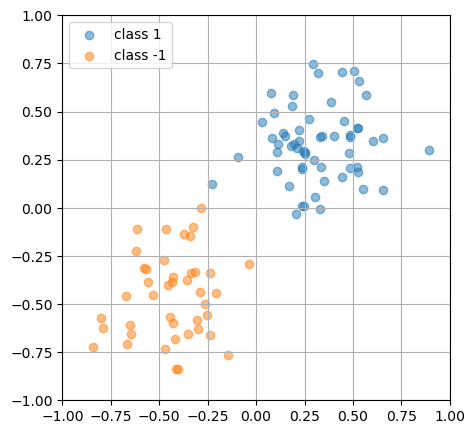

In [35]:
dataset = 'dataset_1'
X_train = np.copy(datasets[dataset]['train']['x'])
y_train = np.copy(datasets[dataset]['train']['y'])

X_test = np.copy(datasets[dataset]['test']['x'])
y_test = np.copy(datasets[dataset]['test']['y'])

kernel = Linear().kernel

Klog = KLogisticRegression(kernel)
Klog.fit(X_train, y_train)

y_pred, precision = Klog.predict(X_test, y_test)

f1_score, precision = Klog.evaluate(y_pred, y_test)
print(f"The f1_score is {f1_score:.2f}, and the classifier's precision is {100*precision:.2f}%")

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plotClassification(X_train, y_train, ax=ax)

The f1_score is 0.85, and the classifier's precision is 85.00%


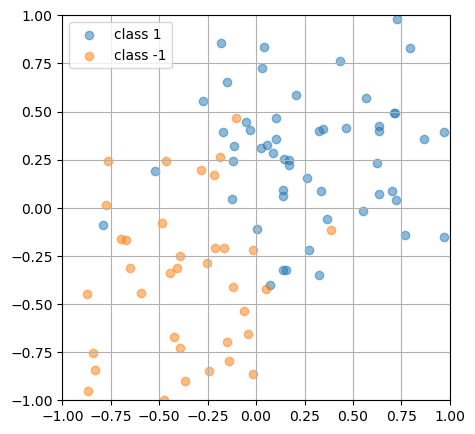

In [34]:
dataset = 'dataset_2'
X_train = np.copy(datasets[dataset]['train']['x'])
y_train = np.copy(datasets[dataset]['train']['y'])

X_test = np.copy(datasets[dataset]['test']['x'])
y_test = np.copy(datasets[dataset]['test']['y'])

kernel = RBF(sigma = 2).kernel

Klog = KLogisticRegression(kernel)
Klog.fit(X_train, y_train)

y_pred, precision = Klog.predict(X_test, y_test)

f1_score, precision = Klog.evaluate(y_pred, y_test)
print(f"The f1_score is {f1_score:.2f}, and the classifier's precision is {100*precision:.2f}%")

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plotClassification(X_train, y_train, ax=ax)

The f1_score is 0.92, and the classifier's precision is 91.50%


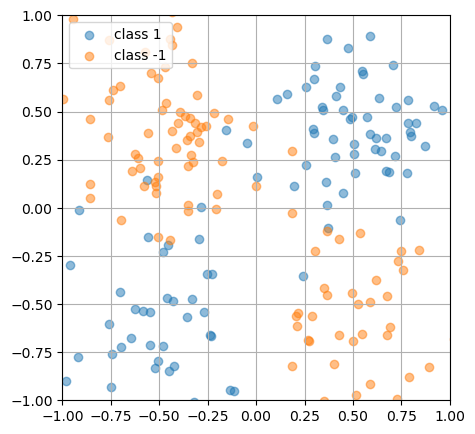

In [36]:
dataset = 'dataset_3'
X_train = np.copy(datasets[dataset]['train']['x'])
y_train = np.copy(datasets[dataset]['train']['y'])

X_test = np.copy(datasets[dataset]['test']['x'])
y_test = np.copy(datasets[dataset]['test']['y'])

kernel = RBF(sigma = 1).kernel

Klog = KLogisticRegression(kernel)
Klog.fit(X_train, y_train)

y_pred, precision = Klog.predict(X_test, y_test)

f1_score, precision = Klog.evaluate(y_pred, y_test)
print(f"The f1_score is {f1_score:.2f}, and the classifier's precision is {100*precision:.2f}%")

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plotClassification(X_train, y_train, ax=ax)